In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carrega a tabela imortação
exp_soja=pd.read_csv('/home/andre301267/git/Pricing-Fertilizer/DB/temp/exp_soja_ncm.csv')
exp_soja.head(1)

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,UF,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB
0,1997,3,12010090,21,573,PR,1,915100,211741,211741810,59211521


# Anos, meses

In [2]:
%run '/home/andre301267/git/Pricing-Fertilizer/codes/function/Comexstat/verifica_continuidade_tempo.ipynb'

***Função "verifica_continuidade_tempo(comexstat_tab)" disponível***


In [3]:
verifica_continuidade_tempo(exp_soja)

A tabela apresenta todos os anos entre 1997 e 2024.
A tabela apresenta continuidade entre os meses.
As datas vão de 1/1997 a 8/2024.


### Escalona bimestre, trimestre, quadrimestre e semestre

# Carrega tabelas auxiliares

In [4]:
%run '/home/andre301267/git/Pricing-Fertilizer/codes/function/Comexstat/extrai-tab_complementares.ipynb'

Variáveis disponíveis: ncm, ncm_sh, pais,uf_mun,uf,via,urf


In [5]:
exp_soja=exp_soja.rename(columns={'SG_UF_NCM':'uf'})

uf=uf.rename(columns={'SG_UF':'UF'})

In [6]:
via.columns

Index(['CO_VIA', 'NO_VIA'], dtype='object')

In [7]:
t=[ncm, ncm_sh, pais, uf, via, urf]
for y in t:
    exp_soja=exp_soja.merge(y)

# Descarta colunas sem interesse

In [8]:
# List of strings to check
strings_to_exclude = ['ING','ESP','ESP','SEC','PPE','PPI','FAT','CICI','CGCE','SIIT','ISIC','EXP','ISON','SG_UNID']

# Function to check if any of the strings are in the column name
def should_exclude(column_name, strings):
    return any(s in column_name for s in strings)

# Exclude columns whose names contain any of the strings
exp_soja = exp_soja.loc[:, ~exp_soja.columns.to_series().apply(lambda col_name: should_exclude(col_name, strings_to_exclude))]

print(exp_soja.columns)


Index(['CO_ANO', 'CO_MES', 'CO_NCM', 'CO_UNID', 'CO_PAIS', 'UF', 'CO_VIA',
       'CO_URF', 'QT_ESTAT', 'KG_LIQUIDO', 'VL_FOB', 'CO_SH6', 'CO_CUCI_ITEM',
       'NO_NCM_POR', 'NO_SH6_POR', 'CO_SH4', 'NO_SH4_POR', 'CO_SH2',
       'NO_SH2_POR', 'CO_PAIS_ISOA3', 'NO_PAIS', 'CO_UF', 'NO_UF', 'NO_REGIAO',
       'NO_VIA', 'NO_URF'],
      dtype='object')


# Verifica NCM

In [9]:
g=exp_soja.groupby('CO_NCM').KG_LIQUIDO.count().reset_index().rename(columns={'KG_LIQUIDO':'#'}).sort_values(by='#',ascending=False)
g

,CO_NCM,#
3,12019000,19933
10,23040090,18292
6,15079011,13792
1,12010090,11018
4,15071000,7527
9,23040010,6063
7,15079019,3612
2,12011000,804
8,15079090,725
0,12010010,388


In [10]:
import seaborn as sns

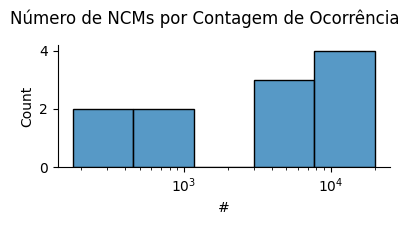

In [11]:
sns.displot(data=g,x='#',log_scale=True,height=2,aspect=2).fig.suptitle('Número de NCMs por Contagem de Ocorrência',y=1.1)
plt.show()

In [12]:
g[g['#']>10**4].merge(ncm[['CO_NCM','NO_NCM_POR']])

,CO_NCM,#,NO_NCM_POR
0,12019000,19933,"Soja, mesmo triturada, exceto para semeadura"
1,23040090,18292,"Bagaços e outros resíduos sólidos, da extração..."
2,15079011,13792,"Óleo de soja, refinado, em recipientes com cap..."
3,12010090,11018,"Outros grãos de soja, mesmo triturados"


Elimina NCM pouco usado

In [13]:
g=g[g['#']>100]
exp_soja=exp_soja.merge(g[['CO_NCM']].drop_duplicates())

# Filtra SH4

In [14]:
col_foco=['CO_SH2','CO_SH4','NO_SH4_POR']
exp_soja.groupby(by=col_foco).KG_LIQUIDO.count()\
.reset_index().sort_values(by='KG_LIQUIDO', ascending=False).rename(columns={'KG_LIQUIDO':'#registros'})\
.set_index(col_foco)

,,,#registros
CO_SH2,CO_SH4,NO_SH4_POR,
12,1201,"Soja, mesmo triturada",32143
15,1507,"Óleo de soja e respectivas fracções, mesmo refinados, mas não quimicamente modificados",25832
23,2304,Tortas e outros resíduos sólidos da extração do óleo de soja,24355


In [15]:
exp_soja=exp_soja[exp_soja.CO_SH4!=3101]

# Filtra SH6

In [16]:
col_foco=['CO_SH2','CO_SH4','CO_SH6','NO_SH6_POR']
count_sh6=exp_soja.groupby(by=col_foco).KG_LIQUIDO.count()\
.reset_index().sort_values(by='KG_LIQUIDO', ascending=False).rename(columns={'KG_LIQUIDO':'#registros'})\
.set_index(col_foco)
count_sh6

,,,,#registros
CO_SH2,CO_SH4,CO_SH6,NO_SH6_POR,
23,2304,230400,Tortas e outros resíduos sólidos da extração do óleo de soja,24355
12,1201,120190,"Soja, mesmo triturada, exceto para semeadura",19933
15,1507,150790,"Óleo de soja e respectivas frações, mesmo refinados, mas não quimicamente modificados",18305
12,1201,120100,"Soja, mesmo triturada",11406
15,1507,150710,"Óleo de soja, em bruto, mesmo degomado",7527
12,1201,120110,"Soja, mesmo triturada, para semeadura",804


In [17]:
exp_soja=exp_soja[~exp_soja.CO_SH6.isin([120110])]

In [18]:
exp_soja.groupby(['CO_NCM','NO_NCM_POR'])[['KG_LIQUIDO','VL_FOB']].sum().sort_values(by=['VL_FOB'],ascending=False)

,,KG_LIQUIDO,VL_FOB
CO_NCM,NO_NCM_POR,,
12019000,"Soja, mesmo triturada, exceto para semeadura",885382121400,391810379215
23040090,"Bagaços e outros resíduos sólidos, da extração do óleo de soja",356642182223,118173649909
12010090,"Outros grãos de soja, mesmo triturados",294259314249,91123760892
15071000,"Óleo de soja, em bruto, mesmo degomado",41433434489,31869569633
23040010,"Farinhas e pellets, da extração do óleo de soja",37616293487,17702274580
15079019,"Óleo de soja, refinado, em recipientes com capacidade menor que 5 litros",4119337473,3203750076
15079011,"Óleo de soja, refinado, em recipientes com capacidade inferior ou igual a 5 litros",1684564849,1974191570
12010010,Soja para semeadura,896097697,295572663
15079090,Outros óleos de soja,625819133,236946264


In [19]:
col_foco=['CO_SH2','CO_SH4','CO_SH6','CO_NCM','NO_NCM_POR']
count_ncm=exp_soja.groupby(by=col_foco).KG_LIQUIDO.count()\
.reset_index().sort_values(by='KG_LIQUIDO', ascending=False).rename(columns={'KG_LIQUIDO':'#registros'})\
.set_index(col_foco)
count_ncm

#registros
CO_SH2 CO_SH4 CO_SH6 CO_NCM   NO_NCM_POR                                                    
12     1201   120190 12019000 Soja, mesmo triturada, exceto para semeadura             19933
23     2304   230400 23040090 Bagaços e outros resíduos sólidos, da extração ...       18292
15     1507   150790 15079011 Óleo de soja, refinado, em recipientes com capa...       13792
12     1201   120100 12010090 Outros grãos de soja, mesmo triturados                   11018
15     1507   150710 15071000 Óleo de soja, em bruto, mesmo degomado                    7527
23     2304   230400 23040010 Farinhas e pellets, da extração do óleo de soja           6063
15     1507   150790 15079019 Óleo de soja, refinado, em recipientes com capa...        3612
                     15079090 Outros óleos de soja                                       725
12     1201   120100 12010010 Soja para semeadura                                        388
15     1507   150790 15079010 Óleo de soja, refinado                                     176

In [20]:
exp_soja=exp_soja.assign(Product=exp_soja.NO_NCM_POR)

# CO_UNID

In [21]:
exp_soja.CO_UNID.unique()

array([21, 10])

In [22]:
exp_soja.groupby('CO_UNID').KG_LIQUIDO.sum()

CO_UNID
10        896097697
21    1622065804561
Name: KG_LIQUIDO, dtype: int64

In [23]:
exp_soja=exp_soja[exp_soja.CO_UNID==21]

In [24]:
exp_soja.drop(columns=['CO_UNID'],inplace=True)

# UF

In [25]:
exp_soja_g=exp_soja.groupby('UF').KG_LIQUIDO.count().sort_values(ascending=False).reset_index().rename(columns={'KG_LIQUIDO':'count_uf'})
exp_soja_g

,UF,count_uf
0,MT,15378
1,PR,12066
2,SP,8459
3,GO,7605
4,RS,7111
5,MS,5517
6,MG,5090
7,SC,4803
8,BA,2553
9,MA,1776


# CO_PAIS

In [26]:
pais=pd.read_csv('/home/andre301267/git/Pricing-Fertilizer/DB/Comexstat/tab_complementares/PAIS.csv',encoding='Latin-1',sep=';')
pais

,CO_PAIS,CO_PAIS_ISON3,CO_PAIS_ISOA3,NO_PAIS,NO_PAIS_ING,NO_PAIS_ESP
0,0,898,ZZZ,Não Definido,Not defined,No definido
1,13,4,AFG,Afeganistão,Afghanistan,Afganistan
2,15,248,ALA,"Aland, Ilhas",Aland Islands,"Alans, Islas"
3,17,8,ALB,Albânia,Albania,Albania
4,20,724,ESP,"Alboran-Perejil, Ilhas","Alboran-Perejil, Islands","Alboran-Perejil, Islas"
...,...,...,...,...,...,...
276,994,898,ZZZ,A Designar,To define,A designar
277,995,898,ZZZ,Bancos Centrais,Central Banks,Bancos Centrales
278,997,898,ZZZ,Organizações Internacionais,International Organizations,Organizaciones Internacionales
279,998,898,ZZZ,Sem informação,Sem informação,Sem informação


# CO_VIA

In [27]:
rank_via=exp_soja.groupby('CO_VIA').KG_LIQUIDO.count().sort_values(ascending=False).reset_index().rename(columns={'KG_LIQUIDO':'count'})

rank_via=rank_via.merge(via)

rank_via

,CO_VIA,count,NO_VIA
0,1,73741,MARITIMA
1,7,4318,RODOVIARIA
2,2,1194,FLUVIAL
3,9,944,MEIOS PROPRIOS
4,4,400,AEREA
5,0,324,VIA NAO DECLARADA
6,12,142,EM MAOS
7,6,35,FERROVIARIA
8,15,31,VICINAL FRONTEIRICO
9,3,6,LACUSTRE


In [28]:
exp_soja=exp_soja[exp_soja.CO_VIA==1]
exp_soja.drop(columns='CO_VIA',inplace=True)

# CO_URF

In [29]:
exp_soja.groupby('CO_URF').KG_LIQUIDO.count().reset_index().rename(columns={'KG_LIQUIDO':'#'}).sort_values('#',ascending=False).tail(25)

,CO_URF,#
18,325100,75
14,317900,73
28,510552,61
27,510353,49
16,320100,36
20,417800,33
24,430151,28
23,420154,25
7,220100,16
32,517602,15


# QT_ESTAT

A coluna QT_ESTAT contém valores em unidades utilizadas no país de origem, que podem não ser igual ao quilograma, mas que não é de interesse deste projeto.

In [30]:
exp_soja.drop(columns='QT_ESTAT',inplace=True)

# Finalizando  

As demais colunas categóricas não mencionadas até aqui serão descartadas.

In [31]:
len(exp_soja)

73741

In [32]:
exp_soja.columns

Index(['CO_ANO', 'CO_MES', 'CO_NCM', 'CO_PAIS', 'UF', 'CO_URF', 'KG_LIQUIDO',
       'VL_FOB', 'CO_SH6', 'CO_CUCI_ITEM', 'NO_NCM_POR', 'NO_SH6_POR',
       'CO_SH4', 'NO_SH4_POR', 'CO_SH2', 'NO_SH2_POR', 'CO_PAIS_ISOA3',
       'NO_PAIS', 'CO_UF', 'NO_UF', 'NO_REGIAO', 'NO_VIA', 'NO_URF',
       'Product'],
      dtype='object')

In [33]:
exp_soja.columns

Index(['CO_ANO', 'CO_MES', 'CO_NCM', 'CO_PAIS', 'UF', 'CO_URF', 'KG_LIQUIDO',
       'VL_FOB', 'CO_SH6', 'CO_CUCI_ITEM', 'NO_NCM_POR', 'NO_SH6_POR',
       'CO_SH4', 'NO_SH4_POR', 'CO_SH2', 'NO_SH2_POR', 'CO_PAIS_ISOA3',
       'NO_PAIS', 'CO_UF', 'NO_UF', 'NO_REGIAO', 'NO_VIA', 'NO_URF',
       'Product'],
      dtype='object')

In [34]:
exp_soja=exp_soja[['CO_ANO','CO_MES','CO_NCM','Product','UF','CO_PAIS',\
                   'CO_URF','KG_LIQUIDO','VL_FOB']]\
.sort_values(by=['CO_ANO','CO_MES','CO_NCM','Product','UF','CO_PAIS','CO_URF']).reset_index(drop=True)

In [35]:
exp_soja.rename(columns={
    'CO_ANO':'year',
    'CO_MES':'month',
    'KG_LIQUIDO':'kg',
    'VL_FOB':'US$_fob',
    'CO_NCM':'ncm',
    'CO_PAIS':'pais',
    'CO_URF':'urf'},inplace=True)

In [36]:
exp_soja

,year,month,ncm,Product,UF,pais,urf,kg,US$_fob
0,1997,1,15071000,"Óleo de soja, em bruto, mesmo degomado",MT,160,915100,6000000,3002191
1,1997,1,15071000,"Óleo de soja, em bruto, mesmo degomado",PR,23,915100,500000,287150
2,1997,1,15071000,"Óleo de soja, em bruto, mesmo degomado",PR,81,915100,5430000,2920399
3,1997,1,15071000,"Óleo de soja, em bruto, mesmo degomado",PR,160,915100,8095000,4129840
4,1997,1,15071000,"Óleo de soja, em bruto, mesmo degomado",PR,573,915100,5700000,2907000
...,...,...,...,...,...,...,...,...,...
73736,2024,8,23040090,"Bagaços e outros resíduos sólidos, da extração...",SP,603,817800,2500000,1039805
73737,2024,8,23040090,"Bagaços e outros resíduos sólidos, da extração...",SP,776,817800,15800000,6792606
73738,2024,8,23040090,"Bagaços e outros resíduos sólidos, da extração...",SP,827,917800,1716060,659271
73739,2024,8,23040090,"Bagaços e outros resíduos sólidos, da extração...",TO,23,917800,4724838,1826528


In [37]:
exp_soja.to_csv('/home/andre301267/git/Pricing-Fertilizer/DB/temp/exp_soja_ncm_cat.csv',index=False)